# Inverse problem: from the observation can we find the causes?
 1. Find the initial state of the system?
 2. Find the source/boundary conditions?

## What's inverse problem

An inverse problem in science is the process of calculating from a set of observations the causal factors that produced them. It is called an inverse problem because it starts with the effects and then calculates the causes. It is the inverse of a forward problem, which starts with the causes and then calculates the effects. (wikipedia)

1. Hear the shape of the drum
https://www.youtube.com/watch?v=bkJZbyrfx-Q

2. Geophysics as the start of inverse problem
https://www.youtube.com/watch?v=8h35KsRD0c0

## Let's focus on the question 1.

### A naive solution to the inverse problem

For the forward problem,

$$  \mathbf{C}^{n+1} = \mathbf{A} ~\mathbf{C}^n + \mathbf{S}^{n}$$.

If $\mathcal{A}$ is invertible, a naive solution to the inverse problem is simply to set

$$  \mathbf{C}^{n} =  \mathbf{A}^{-1} ~\mathbf{C}^{n+1} - \mathbf{A}^{-1} ~ \mathbf{S}^{n}$$

For simplicity, let's assume $S=0$. The initial state of the system can be obtained by

$$  \mathbf{C}^{0} =  \mathbf{A}^{-n_t} ~\mathbf{C}^{n_t} $$

The code below shows that:
- for a very coarse mesh (`nx = 10`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 50`) and/or even small measurement noise (`noise_std_dev = 1e-9`) the naive solution is garbage

In [134]:
import numpy as np
from sklearn.metrics import r2_score
import chaospy

def A_diff_advection(K, deltax, deltat, J, U):
    Ks = K*deltat/deltax**2
    Us = U*deltat/2/deltax
    A = np.diag(np.ones(J-1)*(Ks+Us), -1) + np.diag(np.ones(J)*(1-2*Ks), 0) + np.diag(np.ones(J-1)*(Ks-Us), 1)
    A[0,0]= 2*Us-Ks  # BC1
    A[1,0]= Ks-2*Us
    A[-1,-2] = Ks-2*Us
    A[-1,-1] = 2*Us- Ks # BC2
    return A

In [135]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

CFL: 0.09999999999999999


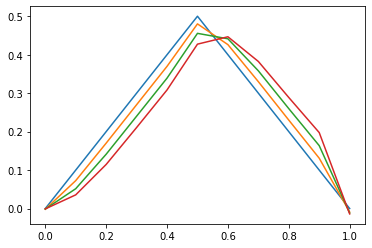

In [136]:
# forward problem

import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

K =0.03
J =10      #40
deltax = 1/J
deltat= 0.01
x=np.linspace(0,1,J+1)
U=1
S=np.zeros_like(x)

print('CFL:',U*deltat/deltax)

A = A_diff_advection(K, deltax, deltat, J+1, U)

C = 0.5 - np.abs(x-0.5)
C0= C

for i in range(0,10):
    if i%3 == 0:
        plt.plot(x,C)
    C = A @ C + S
C_f = C
# adding noise
err = 0 #1e-9
C_obs=C+ err*np.random.randn(C.shape[0])

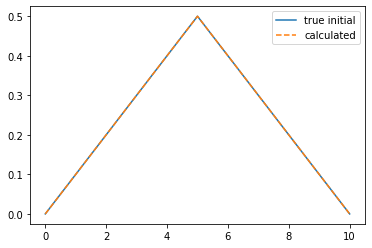

In [137]:
# naive inverse
A_inv = np.linalg.inv(A)

C=C_obs
for i in range(0,10):
    C = np.matmul(A_inv, C) + S

plt.plot(C0, label='true initial')
plt.plot(C,'--', label='calculated')
plt.legend()
plt.show()

## ?? What happen if we run with
1. J=40
2. err = 1e-9
3. J=40 and err = 1e-9

## What can we do?

0.1344998541101885


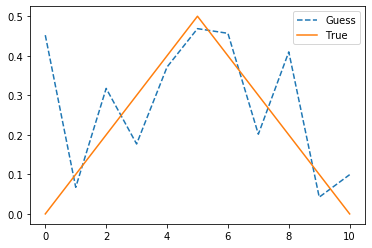

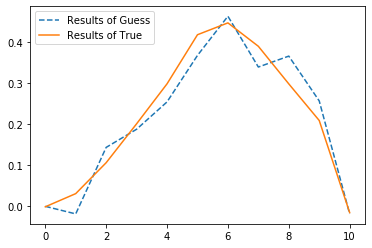

In [138]:
num_try=int(1000)

# Naive Monte Carlo Simulation
error=1e10
C0_=[]
for i in range(0,num_try):
    C0_guess = np.random.uniform(0,0.5,C.shape[0])
    C = C0_guess
    for i in range(0,10):
        C = A@C + S
    error_new = np.linalg.norm(C-C_obs)
    if error_new < error:
        error = error_new
        C0_ = C0_guess
        C_f_ = C
print(error)
plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

plt.plot(C_f_,'--',label='Results of Guess')
plt.plot(C_f,'-',label='Results of True')
plt.legend()
plt.show()


<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-57099-0_32/MediaObjects/449093_1_En_32_Figa_HTML.gif">



<img src="https://imcut.jollychic.com//uploads/jollyimg/imageLibrary/201803/4EN/10/IL201803101945486405.jpg" height="200" width="200">

http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/

0.10996166161750773


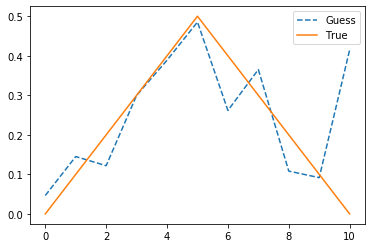

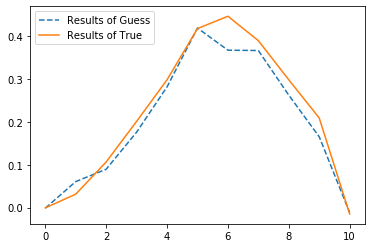

In [139]:
# Latin Hyper Cube Sampling

error=1e10
r2=-10
C0_=[]
# num_try=int(1e2)
C0_guess_matrix=chaospy.create_latin_hypercube_samples(order=num_try, dim=C.shape[0]).T*0.5

for C0_guess in C0_guess_matrix:
#     C0_guess = np.squeeze(chaospy.create_latin_hypercube_samples(order=C.shape[0], dim=1))*0.5
    C = C0_guess
    for i in range(0,10):
        C = np.matmul(A, C) + S
    error_new = np.linalg.norm(C-C_obs)
    if error_new < error:
        error = error_new
        C0_ = C0_guess
        C_f_ = C
print(error)
plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

plt.plot(C_f_,'--',label='Results of Guess')
plt.plot(C_f,'-',label='Results of True')
plt.legend()
plt.show()

In [140]:
import sobol_seq
C0_guess_matrix=sobol_seq.i4_sobol_generate(J, num_try)*0.5

error=1e10
r2=-10
C0_=[]

for C0_guess in C0_guess_matrix:
#     C0_guess = np.squeeze(chaospy.create_latin_hypercube_samples(order=C.shape[0], dim=1))*0.5
    C = C0_guess
    for i in range(0,10):
        C = np.matmul(A, C) + S
    error_new = np.linalg.norm(C-C_obs)
    if error_new < error:
        error = error_new
        C0_ = C0_guess
        C_f_ = C
print(error)
plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

plt.plot(C_f_,'--',label='Results of Guess')
plt.plot(C_f,'-',label='Results of True')
plt.legend()
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 11)

### Challenge:
Re-run the cases above with num_try=1, 10, 100, 1000, and 10000
List your discovery and discuss

## Solving the inverse problem using optimization

In [ ]:
def f(x):
    for i in range(0,10):
        x = np.matmul(A, x) + S
    r2=r2_score(x,C_f)
#     print(r2)
    return -r2

In [ ]:
# simple optimization
import scipy.optimize as opt

C_init = np.zeros_like(C)+0.25
C0_ = opt.minimize(f, C_init).x

plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

In [ ]:
# regulization
# continuous?

C0_prior=gaussian(x,0.5,0.1)*0.5
alpha=0.1

def f_reg(x):
    x0=x
    for i in range(0,10):
        x = np.matmul(A, x) + S
#     obj=r2_score(x,C_f)-alpha*np.linalg.norm(x0-C0_prior)
    obj=np.linalg.norm(x-C_f)+alpha*np.linalg.norm(np.diff(x0))
    #     print(r2)
    return obj

C_init = np.zeros_like(C)+0.25
C0_ = opt.minimize(f_reg, C_init).x
print(np.linalg.norm(C0-C0_))

# plt.plot(C0_prior,label='Prior')
# plt.plot(C0,'-',label='True')
# plt.legend()
# plt.show()

plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()


In [ ]:
# regulization
# gaussian shape?

C0_prior=gaussian(x,0.5,0.1)*0.5
alpha=0.01

def f_reg(x):
    x0=x
    for i in range(0,10):
        x = np.matmul(A, x) + S
#     obj=r2_score(x,C_f)-alpha*np.linalg.norm(x0-C0_prior)
    obj=np.linalg.norm(x-C_f)+alpha*np.linalg.norm(x0-C0_prior)
    #     print(r2)
    return obj

C_init = np.zeros_like(C)+0.25
C0_ = opt.minimize(f_reg, C_init).x
print(np.linalg.norm(C0-C0_))

plt.plot(C0_prior,label='Prior')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

plt.plot(C0_,'--',label='Guess')
plt.plot(C0,'-',label='True')
plt.legend()
plt.show()

# Challenge:

1. What other priors can you use? Can you create your own one by modifying your code above?
2. So far, we assume we could make a complete measurement. But what if we can only measure at x=0, 0.2, 0.4, ... 1?

# Inverse problem for source terms
## Simulation with the source term

In [ ]:
K =0.03
J =30
deltax = 1/J
deltat= 0.0125
x=np.linspace(0,1,J)
U=0.1
S=np.zeros_like(x)
S[10]=.1

print('CFL:',U*deltat/deltax)

A = A_diff_advection(K, deltax, deltat, J, U)

C = np.zeros_like(x)

for i in range(0,11):
    if i%2 == 0:
        plt.plot(x,C,label='i='+str(i))
    C = np.matmul(A, C) + S
C_f = C

plt.legend()
plt.show()

In [ ]:
S0_prior=gaussian(x,0.5,0.1)*0.2
alpha=0.1

def f_reg(x):
    S0=x
    C=np.zeros_like(x)
    for i in range(0,10):
        C = np.matmul(A, C) + S0
#     obj=r2_score(x,C_f)-alpha*np.linalg.norm(x0-C0_prior)
    obj=np.linalg.norm(C-C_f)+alpha*np.linalg.norm(S0-S0_prior)
    #     print(r2)
    return obj

C_init = np.zeros_like(C)+0.05
S0_ = opt.minimize(f_reg, C_init).x
print(np.linalg.norm(S0_-S))

plt.plot(S0_prior,label='Prior')
plt.plot(S,'-',label='True')
plt.legend()
plt.show()

plt.plot(S0_,'--',label='Guess')
plt.plot(S,'-',label='True')
plt.legend()
plt.show()

## Challenge:
If we can only make an observation at one point over time (a time series at one point), can we infer the source distribution?

1. How many data points do we need?
2. What methods are available?
3. Can you code it?